# Inspector tutorial

#### What is inspector ?  
   Vai_q_pytorch provides a function called inspector to help users diagnose neural network (NN) models under different device architectures. The inspector can predict target device assignments based on hardware constraints.The generated inspection report can be used to guide  users to modify or optimize the NN model, greatly reducing the difficulty and time of deployment. It is recommended to inspect float models before quantization.

In [26]:
!pip install torchinfo

In [1]:
import torch
import torch.nn as nn
import torchinfo

In [2]:
# Import inspector API
# 
# Note:
# You can ignore warning message related with XIR. 
# The inspector relies on 'vai_utf' package. In conda env vitis-ai-pytorch in Vitis-AI docker, vai_utf is ready. But if vai_q_pytorch is installed by source code, it needs to install vai_utf in advance.
from pytorch_nndct.apis import Inspector
from pytorch_nndct.apis import torch_quantizer, dump_xmodel

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'

[VAIQ_NOTE]: Loading NNDCT kernels...


In [3]:
!rm -rf inspect

In [4]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

In [5]:
class ResBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.skip_conn = nn.Identity()
        # self.leakyrelu = nn.LeakyReLU(0.1015625)
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1015625),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
        )
        
    def forward(self, X):
        return nn.ReLU()(self.block(X) + self.skip_conn(X))

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net_noise = nn.Linear(100, 100 * 8 * 8)
        self.net_label = nn.Linear(4, 16 * 8 * 8)

        self.leakyrelu = nn.LeakyReLU(0.1015625)
        
        self.net = nn.Sequential(
            nn.ConvTranspose2d(116, 64, kernel_size=5, stride=2, padding=1),
#             nn.Upsample(scale_factor=1.07),
            nn.LeakyReLU(0.1015625),
            ResBlock(64),
            
            nn.ConvTranspose2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.1015625),
            # nn.ZeroPad2d(1),
            ResBlock(128),
            
            nn.ConvTranspose2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.1015625),
            # nn.ZeroPad2d((0, 1, 0, 1)),
            ResBlock(256),
            
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.1015625),
            # nn.ZeroPad2d(1),
            ResBlock(128),
        
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.1015625),
            # nn.ZeroPad2d((0, 1, 0, 1)),
            ResBlock(64),
        
            nn.Conv2d(64, 1, kernel_size=11, stride=1, padding=5),
            nn.Hardsigmoid(),
        )
        
        self.net_noise.apply(init_weights)
        self.net_label.apply(init_weights)
        self.net.apply(init_weights)
        
    def forward(self, noise: torch.Tensor, label: torch.Tensor):
        x_noise = self.net_noise(noise).reshape((1, 8, 8, 100))
        x_label = self.net_label(label).reshape((1, 8, 8, 16))

        x = torch.cat([x_noise, x_label], dim=3)
        x = x.permute((0, 3, 1, 2))

        return self.net(x)[:, :, :256, :256]

In [7]:
# Specify a target name or fingerprint you want to deploy on
target = "DPUCZDX8G_ISA1_B4096"
# Initialize inspector with target
inspector = Inspector(target)


[VAIQ_NOTE]: =>Inspector is initialized successfully with target:
name: DPUCZDX8G_ISA1_B4096
type: DPUCZDX8G
isa_version: 1


In [8]:
# Start to inspect the float model
# Note: visualization of inspection results relies on the dot engine.If you don't install dot successfully, set 'image_format = None' when inspecting.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Generator().to(device)

noises = torch.rand((1, 100), device=device).repeat((1, 1))
labels = torch.tensor([0.72], device=device).repeat((1, 4))

torchinfo.summary(model, input_data=[noises, labels])

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 1, 256, 256]          --
├─Linear: 1-1                            [1, 6400]                 646,400
├─Linear: 1-2                            [1, 1024]                 5,120
├─Sequential: 1-3                        [1, 1, 257, 257]          --
│    └─ConvTranspose2d: 2-1              [1, 64, 17, 17]           185,664
│    └─LeakyReLU: 2-2                    [1, 64, 17, 17]           --
│    └─ResBlock: 2-3                     [1, 64, 17, 17]           --
│    │    └─Sequential: 3-1              [1, 64, 17, 17]           73,856
│    │    └─Identity: 3-2                [1, 64, 17, 17]           --
│    └─ConvTranspose2d: 2-4              [1, 128, 33, 33]          204,928
│    └─LeakyReLU: 2-5                    [1, 128, 33, 33]          --
│    └─ResBlock: 2-6                     [1, 128, 33, 33]          --
│    │    └─Sequential: 3-3              [1, 128, 33, 33]      

In [9]:
inspector.inspect(model, (noises, labels,), device=device, output_dir="inspect", image_format="png") 


[VAIQ_NOTE]: =>Start to inspect model...

[VAIQ_NOTE]: =>Quant Module is in 'cpu'.

[VAIQ_NOTE]: =>Parsing Generator...

[VAIQ_NOTE]: Start to trace model...

[VAIQ_NOTE]: Finish tracing.

[VAIQ_NOTE]: Processing ops...


██████████████████████████████████████████████████| 47/47 [00:00<00:00, 1117.65it/s, OpInfo: name = return_0, type = Ret


[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(inspect/Generator.py)



[VAIQ_NOTE]: The operators assigned to the CPU are as follows(see more details in 'inspect/inspect_DPUCZDX8G_ISA1_B4096.txt'):
node name                  op Type        hardware constraints
-------------------------  -------------  ----------------------------------
Generator::Generator/2017  strided_slice  DPU does not support strided_slice

[VAIQ_NOTE]: Dot image is generated.(inspect/inspect_DPUCZDX8G_ISA1_B4096.png)

[VAIQ_NOTE]: =>Finish inspecting.


##### Inspection result anaysis:
1. In this toy model, there are three operations will be assigned to cpu. The reasons for being allocated to the CPU are shown in the column of hardware constraints.
2. The target device of an input node is determined by its consumer.
3. Here, we found that a special permute operation("ToyModel::ToyModel/AdaptiveAvgPool2d[adaptive_avg_pool2d]/146_sink_transpose_0") is inserted by quantizer. Due to data layout difference between Pytorch('NCHW') and XIR('NHWC'), if quantizer inserts some permutes(which the node message in inspect file will inform us about), these permutes may prevent the entire model from being deployed to the target device. Sometimes, we can cancel out this automatically inserted permute by inserting a permute in the original float model, sometimes, we can't.
4. If you want more details about the inspection, see the inspection report under the output directory you specified.
5. The dot image can help you to analyze inspection result in a more intuitive way. "svg" and "png" format are both supported.


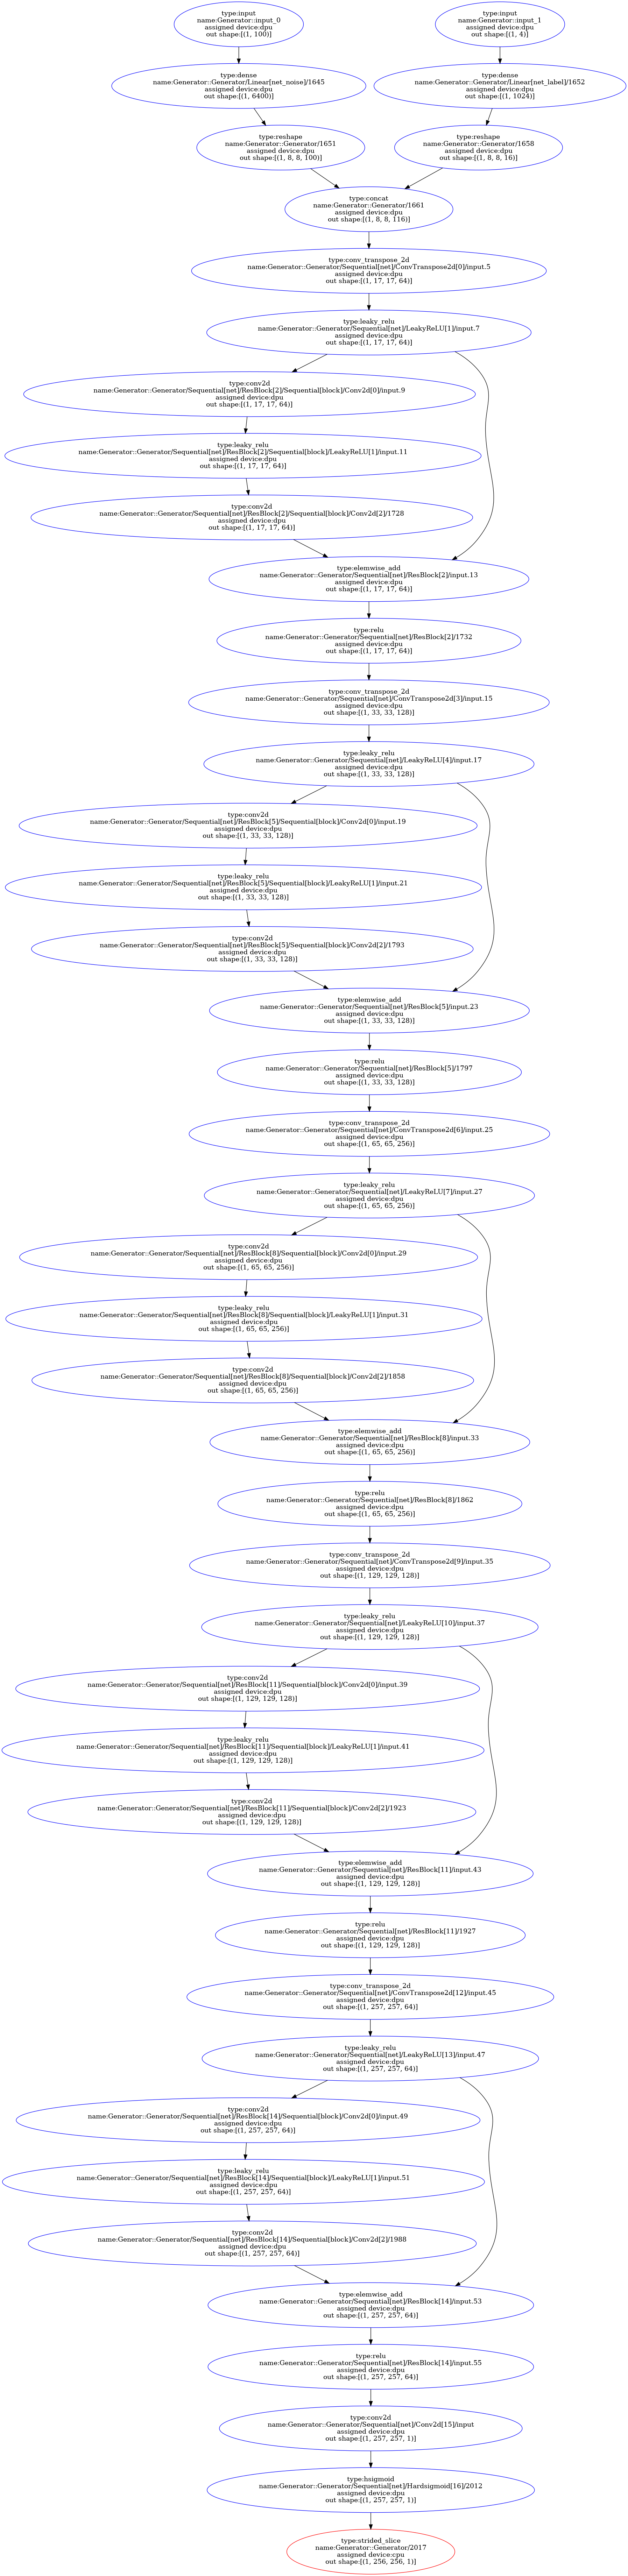

In [10]:
# Show the dot image
from IPython.display import Image
Image('inspect/inspect_DPUCZDX8G_ISA1_B4096.png')

##### Inspection result anaysis:
Finally, under the guidance of the inspector, the entire ToyModel can be deployed on the DPU.

In [11]:
!cat inspect/inspect_DPUCZDX8G_ISA1_B4096.txt

# The 'inspect.txt' file is used to show all the details of each operation in NN model.
# Field Description:
# target info: target device information.
# inspection summary: summary report of inspection# graph name: The name of graph representing of the NN model.
# node name: The name of node in graph.
# input nodes: The parents of the node.
# output nodes: The children of node.
# op type: The type of operation.
# output shape: The shape of node output tensor(Data layout follows XIR requirements).
# op attributes: The attributes of operation.(The description is consistent with that of XIR)
# assigend device: The device type on which the operation execute.
# hardware constrains: If the operation is assigned to cpu. This filed will give some hits about why the DPU does not support this operation.
# node messages: This filed will give some extra information about the node.(For example, if quantizer need to insert a permute operation to convert data layout from 'NCHW' to 'NHWC' or from 'NCH

##### How to deploy this entire model on DPU:
1. Find the location of CPU operations in original model. All the details of operations are shown in inspect_{target}.txt, including source range, points to a source which is a stack track and helps to find the exact location of this operation in source code. Take resize op as a example, from source range, we can find the location of resize op in #3 input block line 11.  
node name: ToyModel::ToyModel/Upsample[upsample]/input.3  
...  
op type: resize  
...  
source range:  
...  
<font color=red>ipython-input-3-7ec1fc6b678f(11): forward</font>  
...

  

2. Modify the original model according to the hardware constrains message and try to cancel out the permute inserted by quantizer with by inserting a permute in the original float model(more details see hints in inspect_{target}.txt)

In [22]:
net_g = torch.load('50_g.pt', map_location=torch.device('cpu'))

In [13]:
noises = torch.rand((1, 100), device=device).repeat((1, 1))
labels = torch.tensor([0.72], device=device).repeat((1, 4))
net_g(noises, labels).shape

torch.Size([1, 1, 256, 256])

In [14]:
torchinfo.summary(net_g, input_data=[noises, labels])

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 1, 256, 256]          --
├─Linear: 1-1                            [1, 6400]                 646,400
├─Linear: 1-2                            [1, 1024]                 5,120
├─Sequential: 1-3                        [1, 1, 257, 257]          --
│    └─ConvTranspose2d: 2-1              [1, 64, 17, 17]           185,664
│    └─LeakyReLU: 2-2                    [1, 64, 17, 17]           --
│    └─ResBlock: 2-3                     [1, 64, 17, 17]           --
│    │    └─Sequential: 3-1              [1, 64, 17, 17]           73,856
│    │    └─Identity: 3-2                [1, 64, 17, 17]           --
│    └─ConvTranspose2d: 2-4              [1, 128, 33, 33]          204,928
│    └─LeakyReLU: 2-5                    [1, 128, 33, 33]          --
│    └─ResBlock: 2-6                     [1, 128, 33, 33]          --
│    │    └─Sequential: 3-3              [1, 128, 33, 33]      

In [17]:
quant_mode='calib'

output_dir='quant_output'

quantizer = torch_quantizer(quant_mode, net_g, input_args=(noises,labels), device=device, output_dir=output_dir)

quant_model = quantizer.quant_model

output= quant_model(noises, labels)

quantizer.export_quant_config()


quantizer.export_xmodel(deploy_check=True, output_dir=output_dir)

print('Done')


[VAIQ_NOTE]: Quant config file is empty, use default quant configuration

[VAIQ_NOTE]: Quantization calibration process start up...

[VAIQ_NOTE]: =>Quant Module is in 'cpu'.

[VAIQ_NOTE]: =>Parsing Generator...

[VAIQ_NOTE]: Start to trace model...

[VAIQ_NOTE]: Finish tracing.

[VAIQ_NOTE]: Processing ops...


██████████████████████████████████████████████████| 47/47 [00:00<00:00, 1166.81it/s, OpInfo: name = return_0, type = Ret


[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(quant_output/Generator.py)

[VAIQ_NOTE]: =>Get module with quantization.



[VAIQ_NOTE]: =>Exporting quant config.(quant_output/quant_info.json)
Done
